In [224]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
import seaborn as sns
import pandas as pd

from sklearn.datasets import make_blobs, load_breast_cancer
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [225]:
def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    # Define colors for each category
    palete = plt.get_cmap('bwr')
    color_cycle = [palete(0.0), palete(1.0)]  # Define specific colors

    # Handle the case where there is only one unique value
    if len(unique_y) == 1:
        single_color = color_cycle[0] if unique_y[0] == 0 else color_cycle[1]
        color_cycle = [single_color] * len(unique_y)

    for i, (yy, color) in enumerate(zip(unique_y, color_cycle)):
        mask = y == yy
        if c is None:
            current_color = color
        elif len(c) > 1:
            current_color = c[i]
        else:
            current_color = c
        
        if np.mean(colorConverter.to_rgb(current_color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, color=current_color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

In [1]:
def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None, alpha=1,                      
                        cm=None, linewidth=None, threshold=None, linestyle="solid"):
    if cm is None:
        cm = ListedColormap(['#0000aa', '#ff2020'])
    # binary?
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0] if threshold is None else [threshold]
        fill_levels = [decision_values.min()] + levels + [
            decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5] if threshold is None else [threshold]
        fill_levels = [0] + levels + [1]
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, alpha=alpha, cmap=cm)
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black", alpha=alpha, linewidths=linewidth,
                   linestyles=linestyle, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


In [227]:
def make_forge():
    # a carefully hand-designed dataset lol
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

In [228]:
def plot_knn_classification(n_neighbors=1):
    X, y = make_forge()

    X_test = np.array([[8.2, 3.66214339], [9.9, 3.2], [11.2, .5]])#
    y_test = np.array([1,1,0])
    dist = euclidean_distances(X, X_test)
    closest = np.argsort(dist, axis=0)

    for x, neighbors in zip(X_test, closest.T):
        for neighbor in neighbors[:n_neighbors]:
            plt.arrow(x[0], x[1], X[neighbor, 0] - x[0],
                      X[neighbor, 1] - x[1], head_width=0, fc='k', ec='k')

    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    test_points = discrete_scatter(X_test[:, 0], X_test[:, 1], clf.predict(X_test), markers="*")
    training_points = discrete_scatter(X[:, 0], X[:, 1], y)
    plt.legend(training_points + test_points, ["training class 0", "training class 1",
                                               "test pred 0", "test pred 1"])
    print('Predicted Values:',clf.predict(X_test))
    print('Actual Values:   ',y_test)
    print("Test set accuracy: {:.2f}".format(clf.score(X_test, y_test)))

Predicted Values: [1 1 0]
Actual Values:    [1 1 0]
Test set accuracy: 1.00


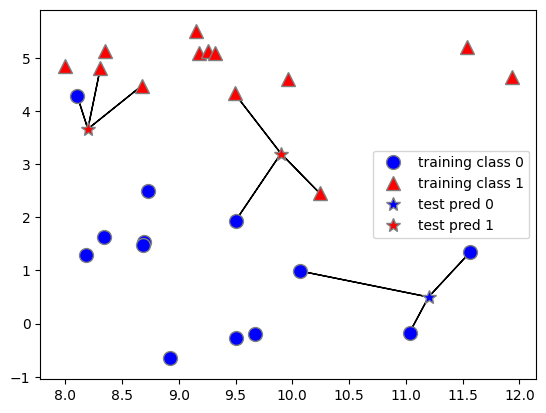

In [229]:
plot_knn_classification(n_neighbors=3)

Predictions:   [1 0 1 0 1 0 0]
Actual values: [1 0 1 0 1 1 0]
Test set accuracy: 0.86


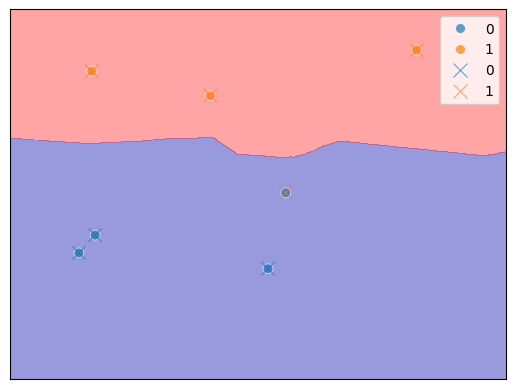

In [230]:
X, y = make_forge()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, y_train)

print('Predictions:   {}'.format(model.predict(X_test)))
print('Actual values: {}'.format((y_test)))
print('Test set accuracy: {:.2f}'.format(model.score(X_test,y_test)))

plot_2d_separator(model, X, fill=True, eps=0.5, alpha=0.4)
predicted_points = sns.scatterplot( x=X_test[:,0], y=X_test[:,1], hue=model.predict(X_test), marker='o', s=50, alpha=0.7)
actual_points = sns.scatterplot( x=X_test[:,0], y=X_test[:,1], hue=y_test, marker='x', s=90, alpha=0.7)


In [231]:
def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None, alpha=1,                      
                        cm=cm2, linewidth=None, threshold=None, linestyle="solid"):
    # binary?
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0] if threshold is None else [threshold]
        fill_levels = [decision_values.min()] + levels + [
            decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5] if threshold is None else [threshold]
        fill_levels = [0] + levels + [1]
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, alpha=alpha, cmap=cm)
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black", alpha=alpha, linewidths=linewidth,
                   linestyles=linestyle, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


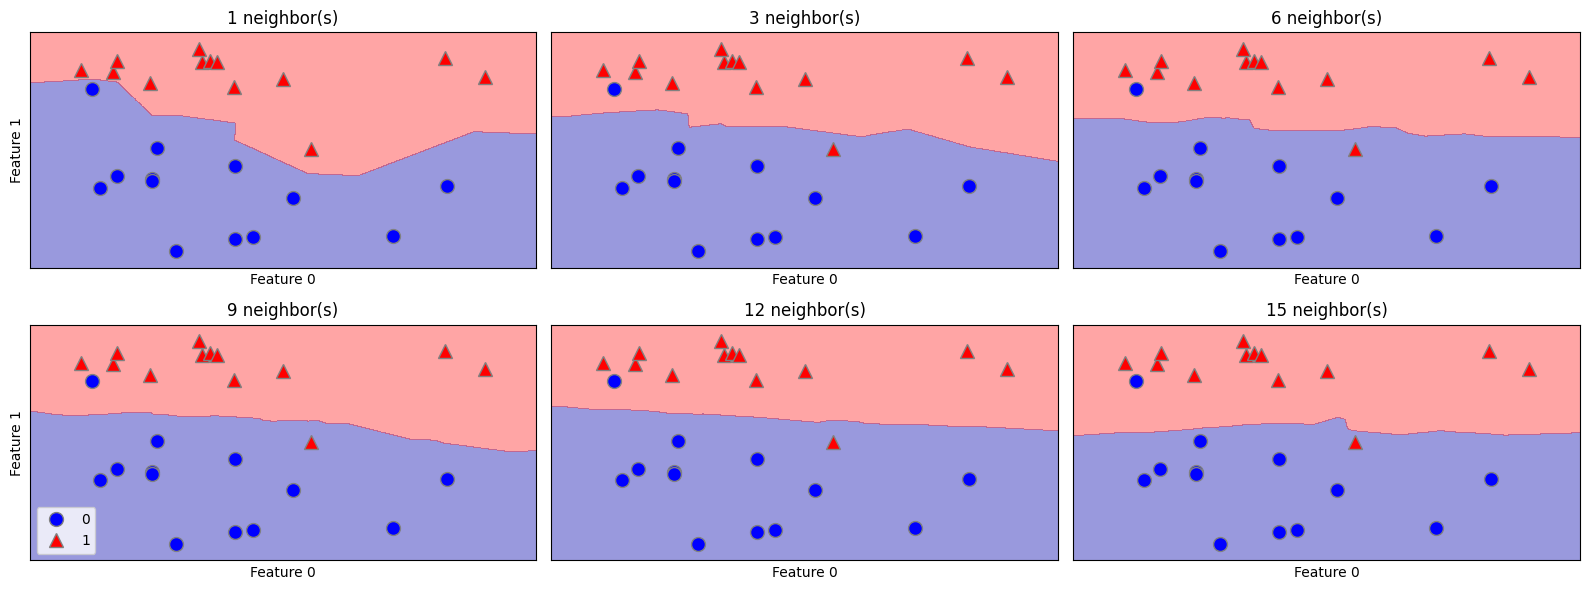

In [232]:
X, y = make_forge()

fig, axes = plt.subplots(2, 3, figsize=(16,6))
axes = axes.flatten()

for n_neighbors, ax in zip([1,3,6,9,12,15], axes):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X, y)
    plot_2d_separator(model, X, fill=True, eps=0.5, ax=ax, alpha=0.4)
    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title(f'{n_neighbors} neighbor(s)')
    ax.set_xlabel('Feature 0')
    
axes[3].legend(loc=3)
axes[0].set_ylabel('Feature 1')
axes[3].set_ylabel('Feature 1')

plt.tight_layout()

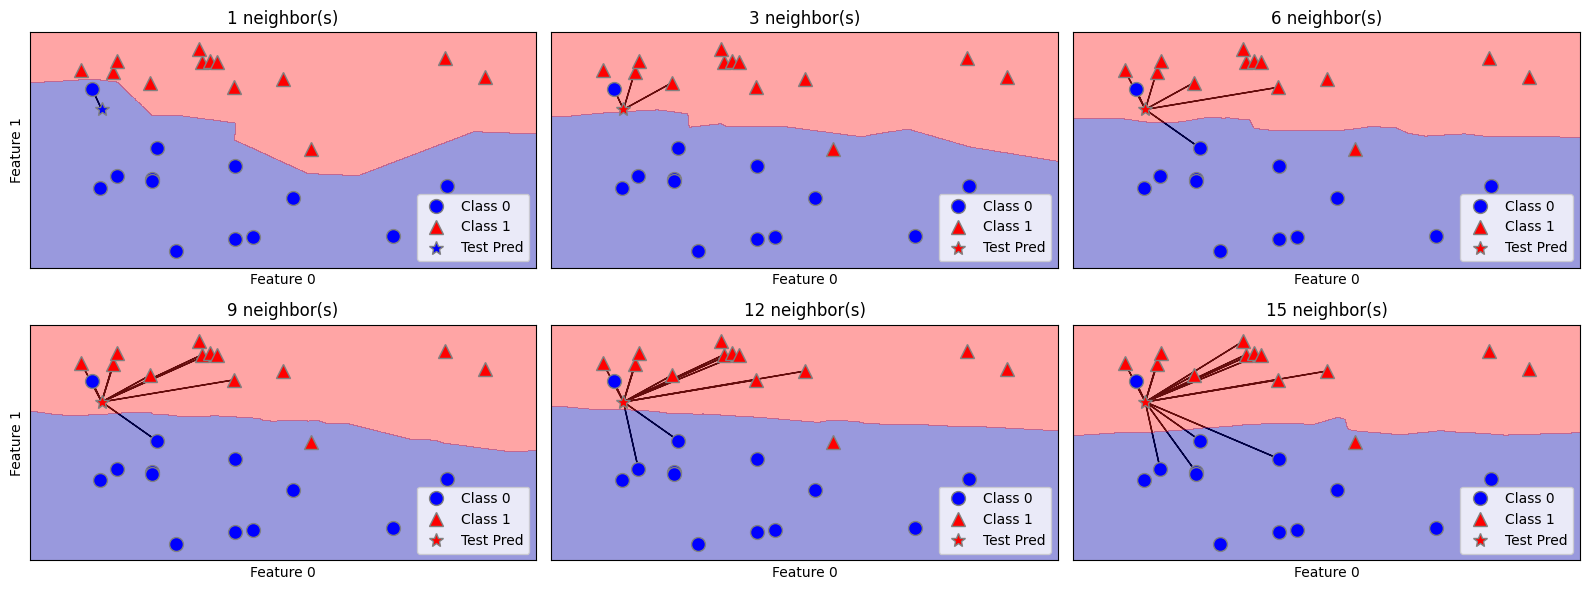

In [233]:
neighbors = [1,3,6,9,12,15]

X_train, y_train = make_forge()

X_test = np.array([[8.2, 3.66214339]]) #, [9.9, 3.2], [11.2, .5]
y_test = np.array([1]) # , 1, 0

fig, axes = plt.subplots(2, 3, figsize=(16,6))
axes = axes.flatten()

for n_neighbors, ax in zip(neighbors, axes):
    dist = euclidean_distances(X_train, X_test)
    closest = np.argsort(dist, axis=0)

    for x, neighbors in zip(X_test, closest.T):
        for neighbor in neighbors[:n_neighbors]:
            ax.arrow(x[0], x[1], X_train[neighbor, 0] - x[0], X_train[neighbor, 1] - x[1], head_width=0, fc='k', ec='k')

    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    test_points = discrete_scatter(X_test[:, 0], X_test[:, 1], predictions, markers="*", ax=ax)
    training_points = discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, ax=ax)

    plot_2d_separator(model, X, fill=True, eps=0.5, ax=ax, alpha=0.4)

    ax.set_title(f'{n_neighbors} neighbor(s)')
    ax.set_xlabel('Feature 0')
    axes[0].set_ylabel('Feature 1')
    axes[3].set_ylabel('Feature 1')
    ax.legend(training_points + test_points, ["Class 0", "Class 1","Test Pred"],loc=4)
    
plt.tight_layout()

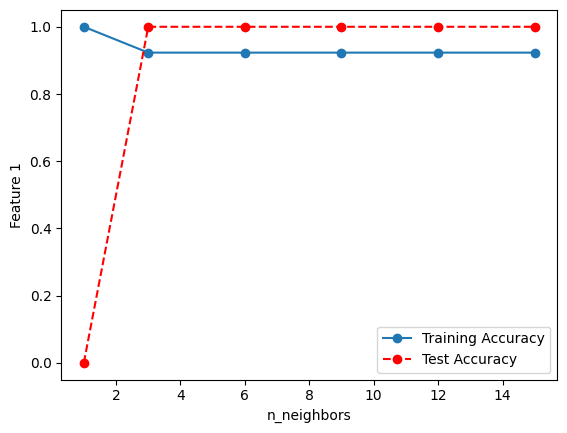

In [234]:
training_accuracy = []
test_accuracy = []
neighbors = [1,3,6,9,12,15]

for n_neighbors in neighbors:
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)

    training_accuracy.append(model.score(X_train,y_train))
    test_accuracy.append(model.score(X_test,y_test))

plt.plot(neighbors, training_accuracy, label='Training Accuracy', marker='o')
plt.plot(neighbors, test_accuracy, label='Test Accuracy', linestyle='--', marker='o', color='red')
plt.ylabel('Feature 1')
plt.xlabel('n_neighbors')
plt.legend()

### Real Example

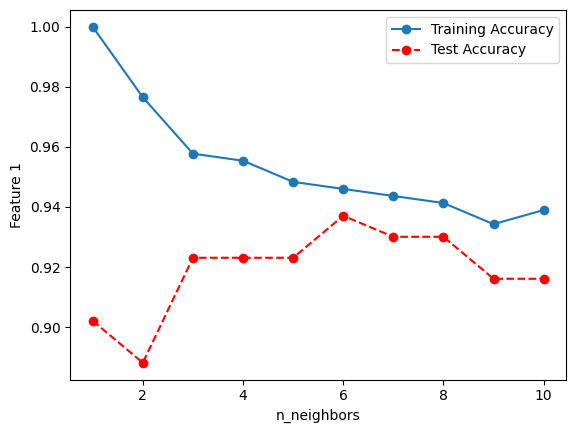

In [235]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=66)

training_accuracy = []
test_accuracy = []
neighbors = range(1,11)

for n_neighbors in neighbors:
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)

    training_accuracy.append(model.score(X_train,y_train))
    test_accuracy.append(model.score(X_test,y_test))

plt.plot(neighbors, training_accuracy, label='Training Accuracy', marker='o')
plt.plot(neighbors, test_accuracy, label='Test Accuracy', linestyle='--', marker='o', color='red')
plt.ylabel('Feature 1')
plt.xlabel('n_neighbors')
plt.legend()